In [39]:
%reload_ext autoreload
%matplotlib inline

import json
import logging
import warnings
from pathlib import Path 

import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

data_root = Path(r'/home/liuzhi/test/data')

In [11]:
def plot_series(ts, title='', xlabel='', ylabel='', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(ts)
    plt.title(title)

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [26]:
dateparse = lambda dates: pd.datetime.strptime(dates, r'%Y-%m-%d')
data = pd.read_csv(f'{data_root}/ak_usd-cny.csv',index_col='Date' ,parse_dates=['Date'], date_parser=dateparse)
data.sort_index(inplace=True)
data.head()

,C,O,H,L,P
Date,,,,,
2015-09-01,6.3645,6.3775,6.3775,6.3635,-0.0019
2015-09-02,6.3559,6.3656,6.3668,6.3555,-0.0014
2015-09-03,6.3559,6.3559,6.3559,6.3559,0.0000
2015-09-04,6.3559,6.3559,6.3559,6.3559,0.0000
2015-09-07,6.3659,6.3574,6.3704,6.3560,0.0016


In [27]:
# 需要分析的时间序列
ts_series = data.C

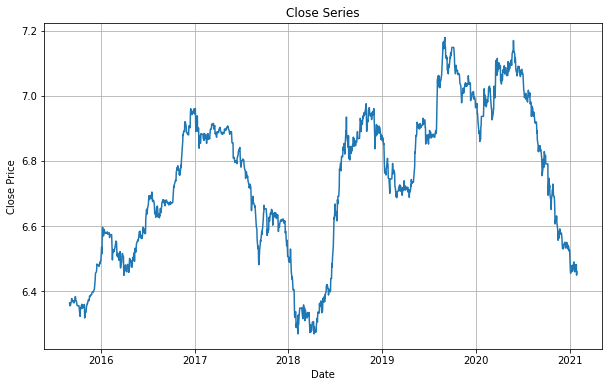

In [28]:
# 时间序列可视化

plot_series(data.C, title='Close Series', xlabel='Date', ylabel='Close Price')

<AxesSubplot:ylabel='Density'>

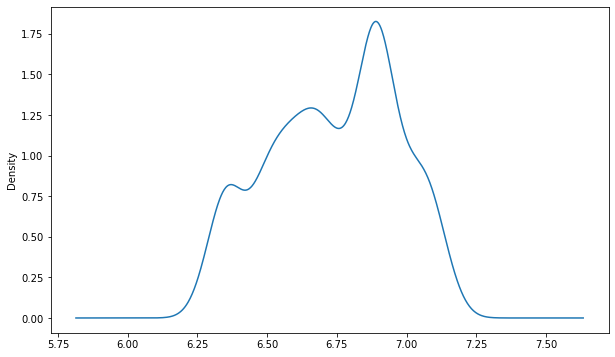

In [30]:
# 时间序列的数据概率分布

plt.figure(figsize=(10, 6))
data.C.plot(kind='kde')

时间序列由三部分组成：趋势，周期，噪点

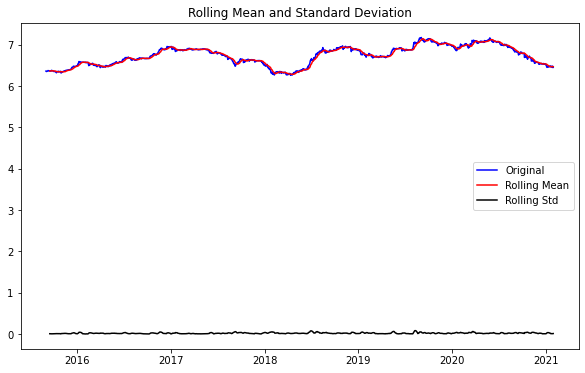

Results of dickey fuller test
Test Statistics                  -1.680956
p-value                           0.440950
No. of lags used                  5.000000
Number of observations used    1408.000000
critical value (1%)              -3.435003
critical value (5%)              -2.863595
critical value (10%)             -2.567864
dtype: float64


In [31]:
# 平稳性检测：均值和方差是常数，即序列是平稳的

plt.figure(figsize=(10, 6))
test_stationarity(data.C)

p-value 大于 0.05 拒绝原假设，即序列是不平稳的。此时可以分离出序列的趋势和周期，以使得数据平稳。

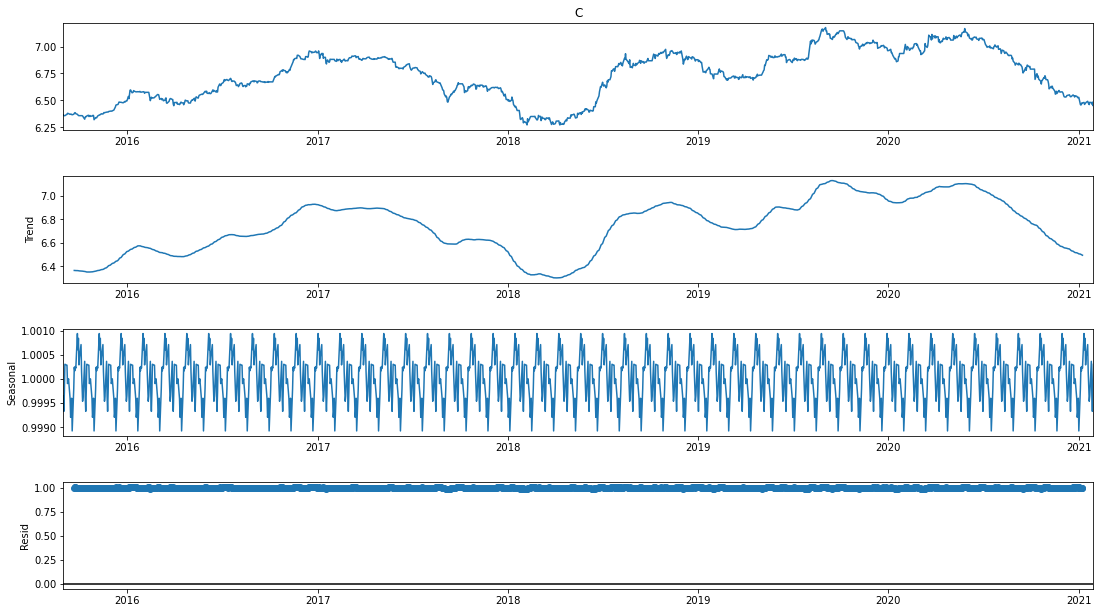

In [32]:
result = seasonal_decompose(ts_series, model='multiplicaive', freq=30)

fig = result.plot()
fig.set_size_inches(16, 9)

2021-01-30 11:41:20,020 WARNING: No handles with labels found to put in legend.


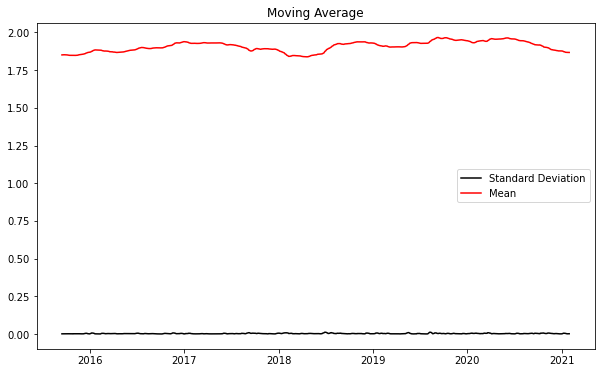

In [33]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(ts_series)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

1340 71


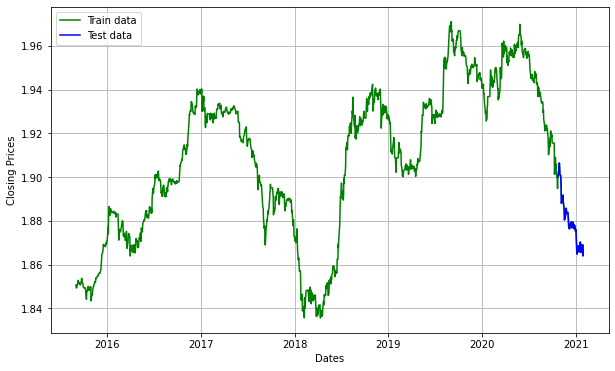

In [53]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.95)], df_log[int(len(df_log)*0.95):]
print(len(train_data), len(test_data))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

使用 Auto ARIMA 自动推导最优 (p, d, q) 参数

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12311.555, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12312.644, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12312.559, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12313.235, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12310.609, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.242 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1340
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6157.617
Date:                Sat, 30 Jan 2021   AIC                         -12313.235
Time:                        12:11:01   BIC                         -12308.035
Sample:                             0   HQIC                        -12311.287
                               - 1340                             

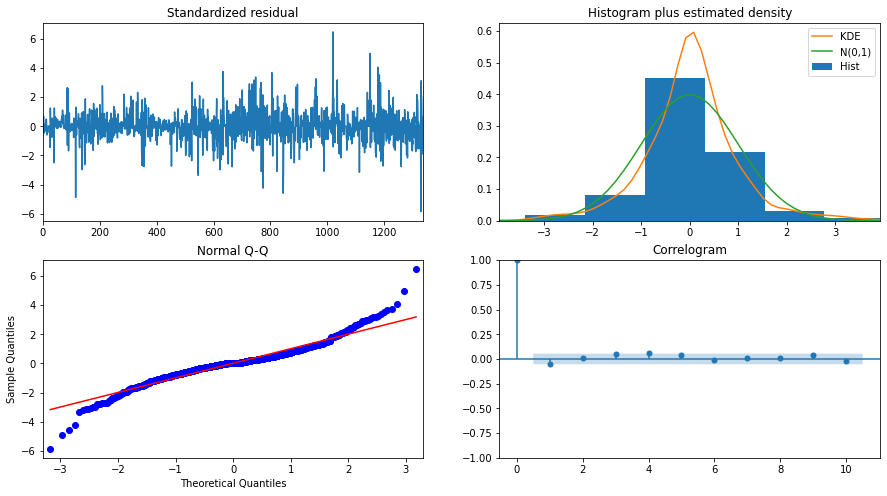

In [59]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

建模

In [61]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.C   No. Observations:                 1339
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6157.777
Method:                           css   S.D. of innovations              0.002
Date:                Sat, 30 Jan 2021   AIC                         -12311.555
Time:                        12:11:53   BIC                         -12301.156
Sample:                    09-07-2015   HQIC                        -12307.659
                         - 10-22-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.765e-05   6.65e-05      0.566      0.572   -9.28e-05       0.000


预测

In [62]:
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  # 95%的置信度

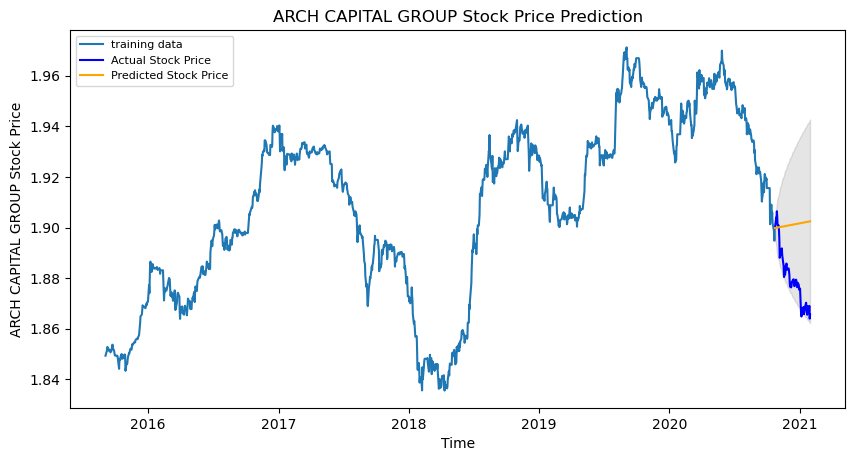

In [63]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

2021-01-30 12:03:14,579 INFO: NumExpr defaulting to 2 threads.
MSE: 0.0030588148360925316
MAE: 0.04707616776390527
RMSE: 0.05530655328342683
MAPE: 0.02495566889228548
